# Imports

In [ ]:
!pip install keras_tuner keras tensorflow numpy pandas scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import keras
import keras_tuner
from keras_tuner import HyperModel, Hyperband

import tensorflow as tf
from tensorflow.python.keras import backend as K

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# Imports needed to add types to function arguments and return values
from typing import List

# Helper functions and classes for data

### Input Data function

This function is used to create the data that is fed into the neural network.

In [ ]:
def create_nn_data(previous_days: List[int], X_history: np.ndarray, X_future: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Create the data for the neural network.
    """
    X_nn, X_nn_future, y_nn = [], [], []

    # Days for which we don't have the previous ones are excluded
    start_date = max(previous_days) * 24

    # Iter over the days in the dataset (we are iterating over the hours 00:00-01:00 of each day)
    for i in range(start_date, len(X_history) - 24 + 1, 24):
        # Get the features of the previous days
        X_seq = []
        for d in previous_days:
            X_seq.append(X_history[i-d*24 : i-(d-1)*24]) #previous_days is a list [1,7] that states which previous days i need to use

        # Concatenate the features of all the previous days sample, e.g. features_prev_day1 && feat_prev_day_7
        features = np.hstack(X_seq) # hstack: concatenate horizontally the features of prev days (hour-by-hour) in one array
        X_nn.append(features)

        # future features of following 24 hours
        X_nn_future.append(X_future[i:i+24])

        # labels of the following 24 hours
        y_nn.append(y[i:i+24])

    # The shape of reshaped X_nn is (window size, 24 * features_per_hours * len_previous_days)
    X_nn = np.array(X_nn)
    X_nn = X_nn.reshape(X_nn.shape[0],-1)

    X_nn_future = np.array(X_nn_future)
    X_nn_future = X_nn_future.reshape(X_nn_future.shape[0],-1)

    # The shape of combined X_nn is (window size, 24 * (features_per_hours * len_previous_days + len_future_features))
    X_combined = np.concatenate((X_nn, X_nn_future), axis=1)

    # The shape of Y_nn is (window size, 24)
    y_nn = np.array(y_nn)

    return X_combined, y_nn


### Sliding Window Class

We implemented this class to make computing input data for the neural network for predictions over long periods easier.

In [ ]:
class SlidingWindowIterator:
    def __init__(self, df: pd.DataFrame, history_features: List[str], future_features: List[str], target: str, starting_date: str, last_prediction_date: str, window_size, previous_days):
        self.df = df
        self.history_features = history_features
        self.future_features = future_features
        self.target = target
        self.starting_date = pd.to_datetime(starting_date)
        self.last_prediction_date = pd.to_datetime(last_prediction_date)
        self.window_size = window_size
        self.previous_days = previous_days
    """
    A class for iterating over a DataFrame using a sliding window approach
    for time series forecasting.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the time series data.
    - history_features (List[str]): List of column names used as features for model training and available only after predictions.
    - future_features (List[str]): List of column names used as features for model training and available before predictions are made.
    - target (str): Name of the target column to be predicted.
    - starting_date (str): Start date of the first window for iteration, given as "YYYY-MM-DD".
    - last_prediction_date (str): Last day (inclusive) to be predicted, given as "YYYY-MM-DD".
    - window_size (int): Fixed size of the sliding window.
    - previous_days (List[int], optional): List of past days to consider as lag features (e.g. [1, 2, 3, 7]).

    Returns:
    - X_nn (np.ndarray): Feature matrix for training the model.
    - y_nn (np.ndarray): Target values corresponding to X_nn.
    - features_for_following_day (np.ndarray): Feature values of the previous days for the next day's prediction.
    - true_price_following_day (float): The actual target value for the next day.
    """

    def __iter__(self):
        # We include the previous days of the starting date to have the features to compute the prediction for the starting date
        self.current_window_starting_date = self.starting_date - pd.Timedelta(days=max(self.previous_days))
        return self

    def __next__(self):
        current_window_end_date = self.current_window_starting_date + pd.Timedelta(days=self.window_size) + pd.Timedelta(days=max(self.previous_days))

        if current_window_end_date > self.last_prediction_date:
            raise StopIteration

        idx = self.df.index

        window_data = self.df[(idx >= self.current_window_starting_date) & (idx < current_window_end_date)]

        X, X_future, y = window_data[self.history_features].to_numpy(), window_data[self.future_features].to_numpy(), window_data[self.target].to_numpy()
        X_nn, y_nn = create_nn_data(self.previous_days, X, X_future, y)

        prev_days_following_days = current_window_end_date - pd.Timedelta(days=max(self.previous_days)) # prediction prevoius days features
        following_day = current_window_end_date + pd.Timedelta(days=1) # prediction end date

        following_day_prediction_data = self.df[(idx >= prev_days_following_days) & (idx < following_day)]
        X_following, X_following_future, y_following = following_day_prediction_data[self.history_features].to_numpy(), following_day_prediction_data[self.future_features].to_numpy(), following_day_prediction_data[self.target].to_numpy()
        features_for_following_day, true_price_following_day = create_nn_data(self.previous_days, X_following, X_following_future, y_following)

        # Increment starting date for next iteration
        self.current_window_starting_date = self.current_window_starting_date + pd.Timedelta(days=1)

        return X_nn, y_nn, current_window_end_date, features_for_following_day, true_price_following_day


### Data class

This class holds all the data used for training and testing the neural network. Moreover, it handles normalization, denormalization and adding new features (such as temporal ones).

In [ ]:
class NeuralNetworkData:
    def __init__(self,
            csv_path: str,
            columns_to_normalize: List[str],
            history_features: List[str],
            future_features: List[str],
            target: str,
            train_start: pd.Timestamp,
            validation_start: pd.Timestamp,
            test_start: pd.Timestamp,
            test_end: pd.Timestamp,
        ):

        # Read the csv and use first column (datetime) as index
        self.df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

        # Save features and target
        self.history_features = history_features
        self.future_features = future_features
        self.target = target

        # Convert dates to pd.Timestamp
        self.train_start = train_start
        self.validation_start = validation_start
        self.test_start = test_start
        self.test_end = test_end

        # Add time features to the dataframe
        self.__add_time_features()

        # Make a copy of target before normalizing
        self.target_copy_column = 'target_copy'
        self.df[self.target_copy_column] = self.df[self.target].copy()

        # Normalize the columns
        self.__normalize_columns(columns_to_normalize)

    def __add_time_features(self) -> None:
        """
        Add time features (sin and cos of hour of day, day of week, week of year) to the dataframe.
        """
        idx = self.df.index

        self.df['hour_sin'] = np.sin(2 * np.pi * idx.hour / 24.0)
        self.df['hour_cos'] = np.cos(2 * np.pi * idx.hour / 24.0)

        self.df['day_of_week_sin'] = np.sin(2 * np.pi * idx.dayofweek / 7.0)
        self.df['day_of_week_cos'] = np.cos(2 * np.pi * idx.dayofweek / 7.0)

        week = idx.isocalendar().week.astype(int)
        self.df['week_of_year_sin'] = np.sin(2 * np.pi * week / 53.0)
        self.df['week_of_year_cos'] = np.cos(2 * np.pi * week / 53.0)

        # Insert the new features in the features list
        new_features = [
            'hour_sin',
            'hour_cos',
            'day_of_week_sin',
            'day_of_week_cos',
            'week_of_year_sin',
            'week_of_year_cos'
        ]

        self.history_features.extend(new_features)
        self.future_features.extend(new_features)

    def __normalize_columns(self, columns_to_normalize: List[str]) -> None:
        """
        Normalize the specified columns of the dataframe using StandardScaler.
        Fit on the range [train_start:test_end], but apply transformation to the entire dataframe.
        Also saves mean and std of the target column in the fitting range.
        """
        self.standardScaler = StandardScaler()

        # Save target statistics based on training range to denormalize later
        self.target_mean = self.df.loc[self.train_start:self.test_end, self.target].mean()
        self.target_std = self.df.loc[self.train_start:self.test_end, self.target].std()

        # Fit on training range
        self.standardScaler.fit(self.df.loc[self.train_start:self.test_end, columns_to_normalize])

        # Transform the entire dataframe
        self.df[columns_to_normalize] = self.standardScaler.transform(self.df[columns_to_normalize])

        print(self.target_mean,self.target_std)

    def denormalize_target(self, target: np.ndarray) -> np.ndarray:
        """
        Denormalize target.
        """
        return target * self.target_std + self.target_mean

    def get_training_and_validation_datasets(self,previous_days) -> None:
        """
        Datasets NN for training & validation .
        """
        idx = self.df.index

        train_start = self.train_start - pd.Timedelta(days=max(previous_days))
        train_df = self.df[(idx >= train_start) & (idx <= self.validation_start)]

        X, X_future, y = train_df[self.history_features].to_numpy(), train_df[self.future_features].to_numpy(), train_df[self.target].to_numpy()
        X_train, y_train = create_nn_data(previous_days, X, X_future, y)

        validation_start = self.validation_start - pd.Timedelta(days=max(previous_days))
        validation_df = self.df[(idx >= validation_start) & (idx < self.test_start)]

        X_valid, X_valid_future, y_valid = validation_df[self.history_features].to_numpy(), validation_df[self.future_features].to_numpy(), validation_df[self.target].to_numpy()
        X_validation, y_validation = create_nn_data(previous_days, X_valid, X_valid_future, y_valid)

        return X_train, y_train, X_validation, y_validation

    def get_testing_window(self, previous_days):
        """
        Returns an iterator of a sliding window over the (training + validation) set to the testing set.
        """

        start_day = self.train_start
        last_prediction_date = self.test_end
        window_size = (self.test_start - self.train_start).days

        return SlidingWindowIterator(
            self.df,
            self.history_features,
            self.future_features,
            self.target,
            start_day,
            last_prediction_date,
            window_size,
            previous_days
        )

    def get_training_validation_datasets(self,previous_days):
        """
        Datasets NN for training & validation .
        """

        idx = self.df.index

        train_start = self.train_start - pd.Timedelta(days=max(previous_days))
        train_df = self.df[(idx >= train_start) & (idx < self.validation_start)]

        X, X_future, y = train_df[self.history_features].to_numpy(), train_df[self.future_features].to_numpy(), train_df[self.target].to_numpy()
        X_train, y_train = create_nn_data(previous_days, X, X_future, y)

        validation_start = self.validation_start - pd.Timedelta(days=max(previous_days))
        validation_df = self.df[(idx >= validation_start) & (idx < self.test_start)]

        X_valid, X_valid_future, y_valid = validation_df[self.history_features].to_numpy(), validation_df[self.future_features].to_numpy(), validation_df[self.target].to_numpy()
        X_validation, y_validation = create_nn_data(previous_days, X_valid, X_valid_future, y_valid)

        return X_train, y_train, X_validation, y_validation


    def get_data(self, column_name: str, start: pd.Timestamp, end: pd.Timestamp):
        """
        Returns a dataframe with the given column within the given dates (included).
        """

        return self.df.loc[start:end, column_name].values

    def get_original_target(self, start: pd.Timestamp, end: pd.Timestamp):
        """
        Returns target before normnalization
        """
        return self.df.loc[start:end, self.target_copy_column].values

# Neural Network

### Metrics

In [ ]:
def smape(y_true, y_pred):
    numerator = 2*K.abs(y_true - y_pred)
    denominator = y_true + y_pred
    return K.mean(numerator /denominator) * 100  # Return the sMAPE in percentage

def rmae(y_true, y_pred, y_naive):
    numerator = K.sum(K.abs(y_true - y_pred))
    denominator = K.sum(K.abs(y_true - y_naive))
    return numerator / denominator

### Hypermodel

In [ ]:
class HyperModel(keras_tuner.HyperModel):

    def __init__(self, data: NeuralNetworkData, len_history_features: int, len_future_features: int):
        self.x_train, self.y_train = None, None
        self.x_val, self.y_val = None, None
        self.data = data
        self.len_history_features = len_history_features
        self.len_future_features = len_future_features

    def build(self,hp):
        model = keras.Sequential()

        # Add input layer
        previous_days = [1,7]

        if hp.Boolean("prev_day_2"):
            previous_days.append(2)
        if hp.Boolean("prev_day_3"):
            previous_days.append(3)

        previous_days.sort()

        input_size = 24 * (self.len_history_features * len(previous_days) + self.len_future_features) # the +6 is due to enriching the input with time features
        model.add(keras.layers.Input(shape=(input_size,)))

        # Hidden layers
        num_hidden_layers = hp.Int('num_layers', 2, 5, default=3)

        for i in range(num_hidden_layers):

            # L1_L2 regularization
            lmbda = hp.Float(f"l1_lambda_{i}", min_value=1e-5, max_value=1e-2, sampling="LOG")
            lmbda2 = hp.Float(f"l2_lambda_{i}", min_value=1e-5, max_value=1e-2, sampling="LOG")

            model.add(
                keras.layers.Dense(
                    units=hp.Int(f"units_{i}", min_value=64, max_value=1024, step=64),
                    activation='relu',
                    kernel_regularizer=keras.regularizers.l1_l2(lmbda, lmbda2),
                    kernel_initializer=keras.initializers.GlorotNormal(seed=0)
                )
            )

            # Insert a dropout layer
            model.add(
                keras.layers.Dropout(
                    rate=hp.Float(
                        'dropout', min_value=0.01, max_value=0.3, step=0.01)
                )
            )

        # Output layer
        model.add(keras.layers.Dense(24))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float('learning_rate', 1e-5, 1e-2,
                sampling = "LOG")
            ),
            loss='mae',
            metrics= [smape]
        )

        # Get the training and validation datasets
        self.x_train, self.y_train, self.x_val, self.y_val = self.data.get_training_validation_datasets(previous_days)

        return model


    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
                        self.x_train, self.y_train,
                        validation_data=(self.x_val, self.y_val),
                        batch_size = hp.Int('batch_size', 7,7*8,7),
                        epochs = 1000, #worst case scenario
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)], #min of 20 epochs before pruning and saving best weights
                        verbose=0,
                        shuffle=True
                         )

    def predict(self,model,X_predictions):
        return model.predict(X_predictions)


# Example usage

### Loading the data

In [ ]:

path = '/content/FR.csv'

history_features = ['Load_AC', 'Gen_SC', 'Sol_DA', 'Won_DA', 'Price_DA'] # features available for previous days
future_features = ['Load_DA'] # features available for the day to predict
target = 'Price_DA'

columns_to_normalize = history_features + future_features + [target]
columns_to_normalize = list(set(columns_to_normalize)) # make them unique

train_start = pd.to_datetime("2016-01-01")
validation_start = pd.to_datetime("2018-01-01")
test_start = pd.to_datetime("2019-01-01")
test_end = pd.to_datetime("2019-12-31")

data = NeuralNetworkData(path,
                         columns_to_normalize,
                         history_features,
                         future_features,
                         target,
                         train_start,
                         validation_start,
                         test_start,
                         test_end)

42.8388656145658 20.32480235035506


### Hyperparameters optimization with Hyperband

In [ ]:
hp = keras_tuner.HyperParameters()
hypermodel = HyperModel(data, len(history_features), len(future_features))

tuner = keras_tuner.Hyperband(hypermodel=hypermodel,
                                objective='val_loss',
                                directory='hyperband_FR_2016_2019',
                                project_name='energy_price')

In [ ]:
tuner.search()

When using Colab, download the found hyperparameters with this cell:

In [ ]:
!zip -r /content/hyperband_FR_2016_2019.zip /content/hyperband_FR_2016_2019
from google.colab import files
files.download("/content/hyperband_FR_2016_2019.zip")

  adding: content/hyperband_FR_2016_2019/ (stored 0%)
  adding: content/hyperband_FR_2016_2019/energy_price/ (stored 0%)
  adding: content/hyperband_FR_2016_2019/energy_price/trial_0009/ (stored 0%)
  adding: content/hyperband_FR_2016_2019/energy_price/trial_0009/trial.json (deflated 82%)
  adding: content/hyperband_FR_2016_2019/energy_price/trial_0009/build_config.json (stored 0%)
  adding: content/hyperband_FR_2016_2019/energy_price/trial_0019/ (stored 0%)
  adding: content/hyperband_FR_2016_2019/energy_price/trial_0019/trial.json (deflated 82%)
  adding: content/hyperband_FR_2016_2019/energy_price/trial_0019/build_config.json (stored 0%)
  adding: content/hyperband_FR_2016_2019/energy_price/trial_0020/ (stored 0%)
  adding: content/hyperband_FR_2016_2019/energy_price/trial_0020/trial.json (deflated 82%)
  adding: content/hyperband_FR_2016_2019/energy_price/trial_0020/build_config.json (stored 0%)
  adding: content/hyperband_FR_2016_2019/energy_price/trial_0036/ (stored 0%)
  adding:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Preparing the model

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]

model = hypermodel.build(best_hp)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 896)            │     1,097,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        57,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,156,568 (4.41 MB)

 Trainable params: 1,156,568 (4.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
previous_days = [1,7]

if best_hp["prev_day_2"]:
    previous_days.append(2)
if best_hp["prev_day_3"]:
    previous_days.append(3)

previous_days.sort()

print("Computing predictions using features of ", previous_days, " previous days as input")

Computing predictions using features of  [1, 2, 3, 7]  previous days as input


### Computing predictions

In [ ]:
# Dataframe to store the prices
end_timestamp = test_end+pd.Timedelta(hours=23)

dates = pd.date_range(start=test_start,
                      end=end_timestamp,
                      freq='h')
true_prices = data.denormalize_target(data.get_data(target, test_start, end_timestamp))
naive_predictor = data.denormalize_target(data.get_data(target, test_start-pd.Timedelta(days=1), end_timestamp-pd.Timedelta(days=1)))

df = pd.DataFrame({
    'true_price': true_prices,
    'prediction': np.nan,
    'naive': naive_predictor,
}, index=dates)
df.index.name = 'Datetime'

# Actual predictions

count = 0

for (X, y, date, X_following, y_following) in data.get_testing_window(previous_days):

    print('Computing prediction for: ', date)

    # Reduce early stopping during the first week
    if count < 7:
        patience = 200
    else:
        patience = 50

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = 'loss',  # Monitor training loss instead of validation loss
        patience = patience,
        restore_best_weights=True #Using the best weights found during training
    )

    history = model.fit(
        X, y,
        batch_size=best_hp['batch_size'],
        epochs=1000,  # Large number, let early stopping handle it
        callbacks=[early_stopping],
        verbose=0
    )

    print("Loss: ", history.history['loss'][-1])

    predictions = model.predict(X_following).flatten()
    predictions = data.denormalize_target(predictions).tolist()

    for h, prediction in enumerate(predictions):
        df.loc[date + pd.Timedelta(hours=h), 'prediction'] = prediction

    count += 1

Computing prediction for:  2019-01-01 00:00:00
Loss:  0.28433677554130554
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Computing prediction for:  2019-01-02 00:00:00
Loss:  0.2791438698768616
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Computing prediction for:  2019-01-03 00:00:00
Loss:  0.2755686938762665
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Computing prediction for:  2019-01-04 00:00:00
Loss:  0.2802923321723938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Computing prediction for:  2019-01-05 00:00:00
Loss:  0.27499255537986755
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Computing prediction for:  2019-01-06 00:00:00
Loss:  0.2751898765563965
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Computing prediction for:  2019-01-07 00:00:00
Loss:  0.28529268503189087
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Computing prediction for:  2019-01-08 00:00:00
Loss:  0.27750295400619507
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Computing prediction for:  2019-01-09 00:00:00
Loss:  0.27948495745658875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/

In [ ]:
df.to_csv("predictionsFR.csv")
files.download("/content/predictionsFR.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

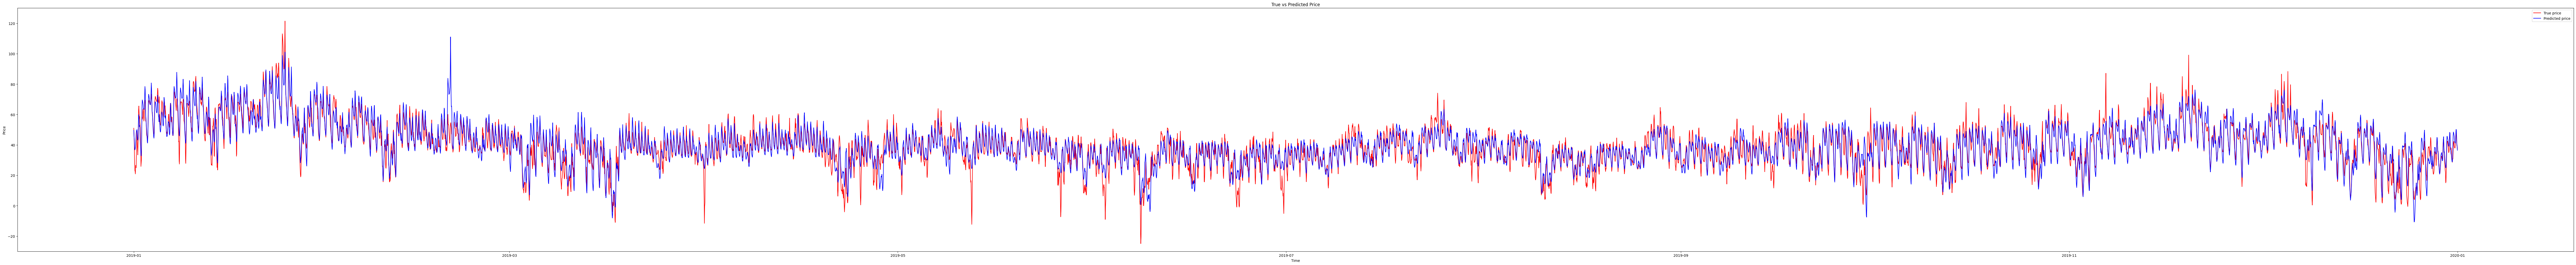

In [ ]:
# new_df = df.loc[pd.Timestamp("2019-01-01 00:00:00"):pd.Timestamp("2019-12-31 23:00:00")]
new_df = df

plt.figure(figsize=(100, 10))
plt.plot(new_df['true_price'], label="True price", color='red')
plt.plot(new_df['prediction'], label="Predicted price", color='blue')

# plt.xlim(pd.Timestamp("2019"),pd.Timestamp("2019")+pd.Timedelta(days=count))

plt.ylim(-30,130)

plt.legend()
plt.tight_layout()
plt.title("True vs Predicted Price", loc='center')
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()


In [ ]:
def smape(y_true, y_pred):
    return np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))
    )

def rmae(y_true, y_pred, y_naive):
    mae_model = np.mean(np.abs(y_pred - y_true))
    mae_naive = np.mean(np.abs(y_naive - y_true))
    return mae_model / mae_naive

# Calculate sMAPE
smape_value = smape(new_df['true_price'], new_df['prediction'])

# Calculate rMAE
rmae_value = rmae(new_df['true_price'], new_df['prediction'], new_df['naive'])

print("sMAPE:", smape_value)
print("rMAE:", rmae_value)

sMAPE: 0.14333395897819373
rMAE: 0.632836233601245


In [ ]:
monthly_smape = df.groupby(df.index.to_period('M')).apply(
    lambda x: smape(x['true_price'], x['prediction'])
)

monthly_smape.index = monthly_smape.index.to_timestamp()

print(monthly_smape)

Datetime
2019-01-01    0.084562
2019-02-01    0.087746
2019-03-01    0.194768
2019-04-01    0.163963
2019-05-01    0.128133
2019-06-01    0.247493
2019-07-01    0.103330
2019-08-01    0.115965
2019-09-01    0.156234
2019-10-01    0.132781
2019-11-01    0.085496
2019-12-01    0.216732
Freq: MS, dtype: float64
